In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Sat Apr 17 09:42:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q -U watermark

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy      : 1.19.5
pandas     : 1.1.5
torch      : 1.8.1+cu101
torchvision: 0.9.1+cu101



In [5]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
train_folders = sorted(glob('/content/drive/MyDrive/70:30_Datasets/70:30_train_test/*'))
len(train_folders)

5

In [7]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

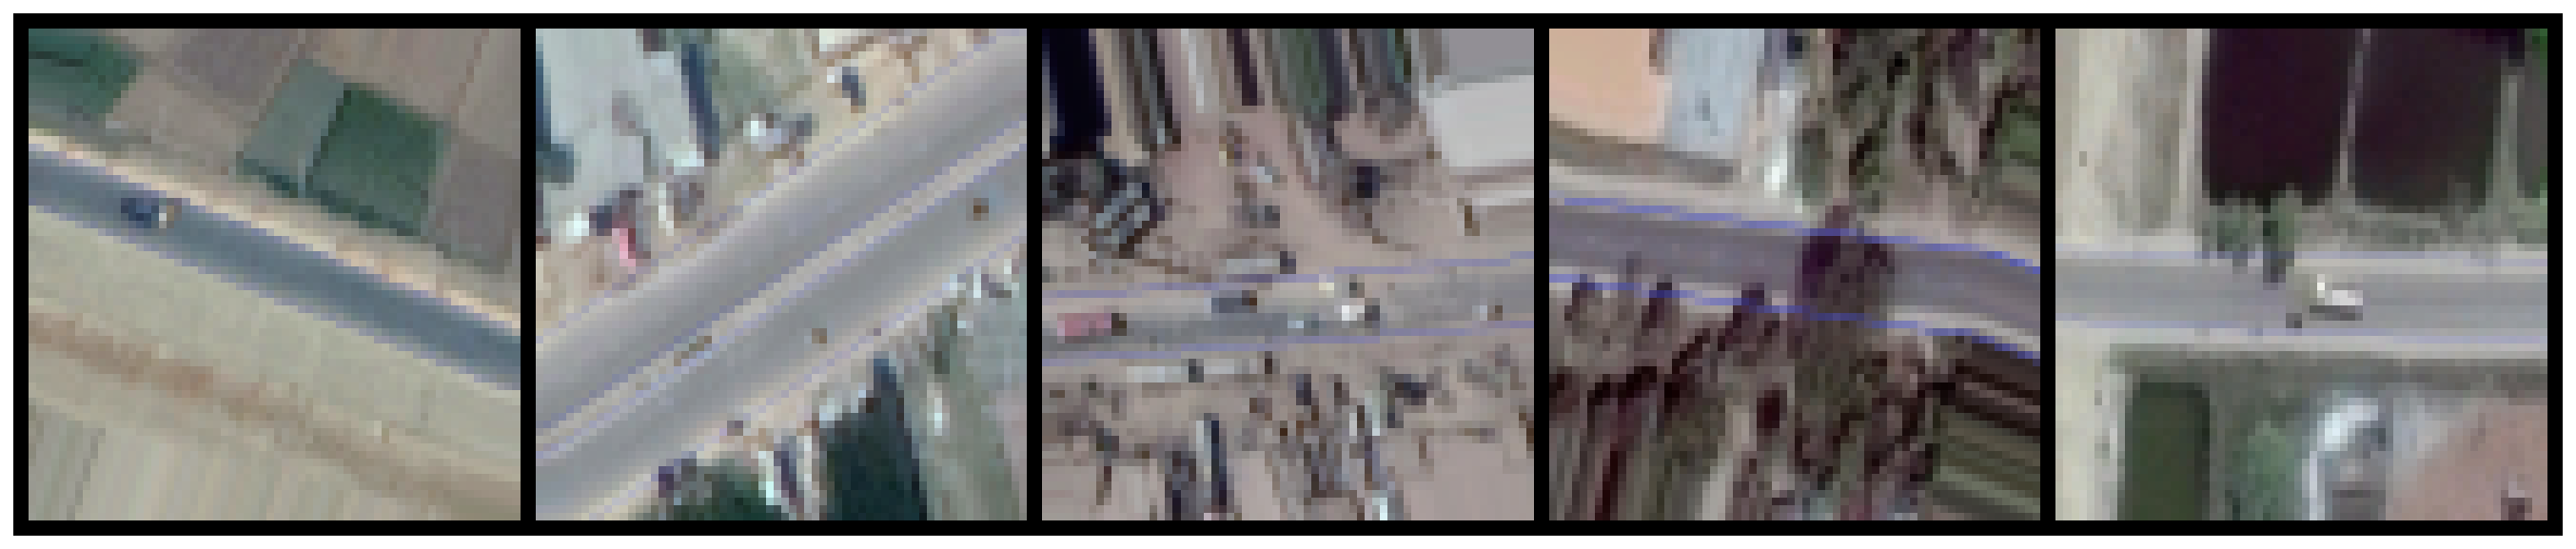

In [8]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in train_folders]
show_sign_grid(sample_images)

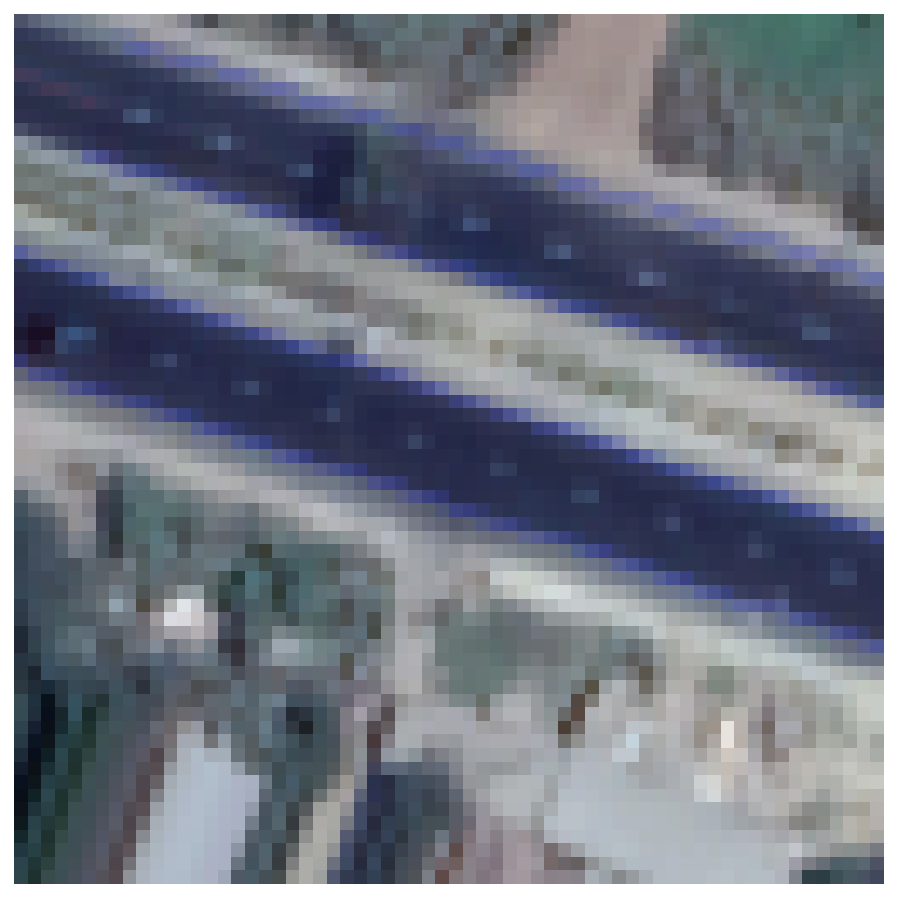

In [9]:
img_path = glob(f'{train_folders[2]}/*png')[20]

show_image(img_path)

In [10]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [11]:
!rm -rf data

DATA_DIR = Path('datax')

DATASETS = ['train', 'val']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [12]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 4228
fair: 4779
good: 4812
poor: 4368
vbad: 3728


In [13]:
#64*64
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.Resize(64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=80),
  T.CenterCrop(size=64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [13]:
#224*224
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.Resize(224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [14]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=32, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [15]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 17530, 'val': 4385}

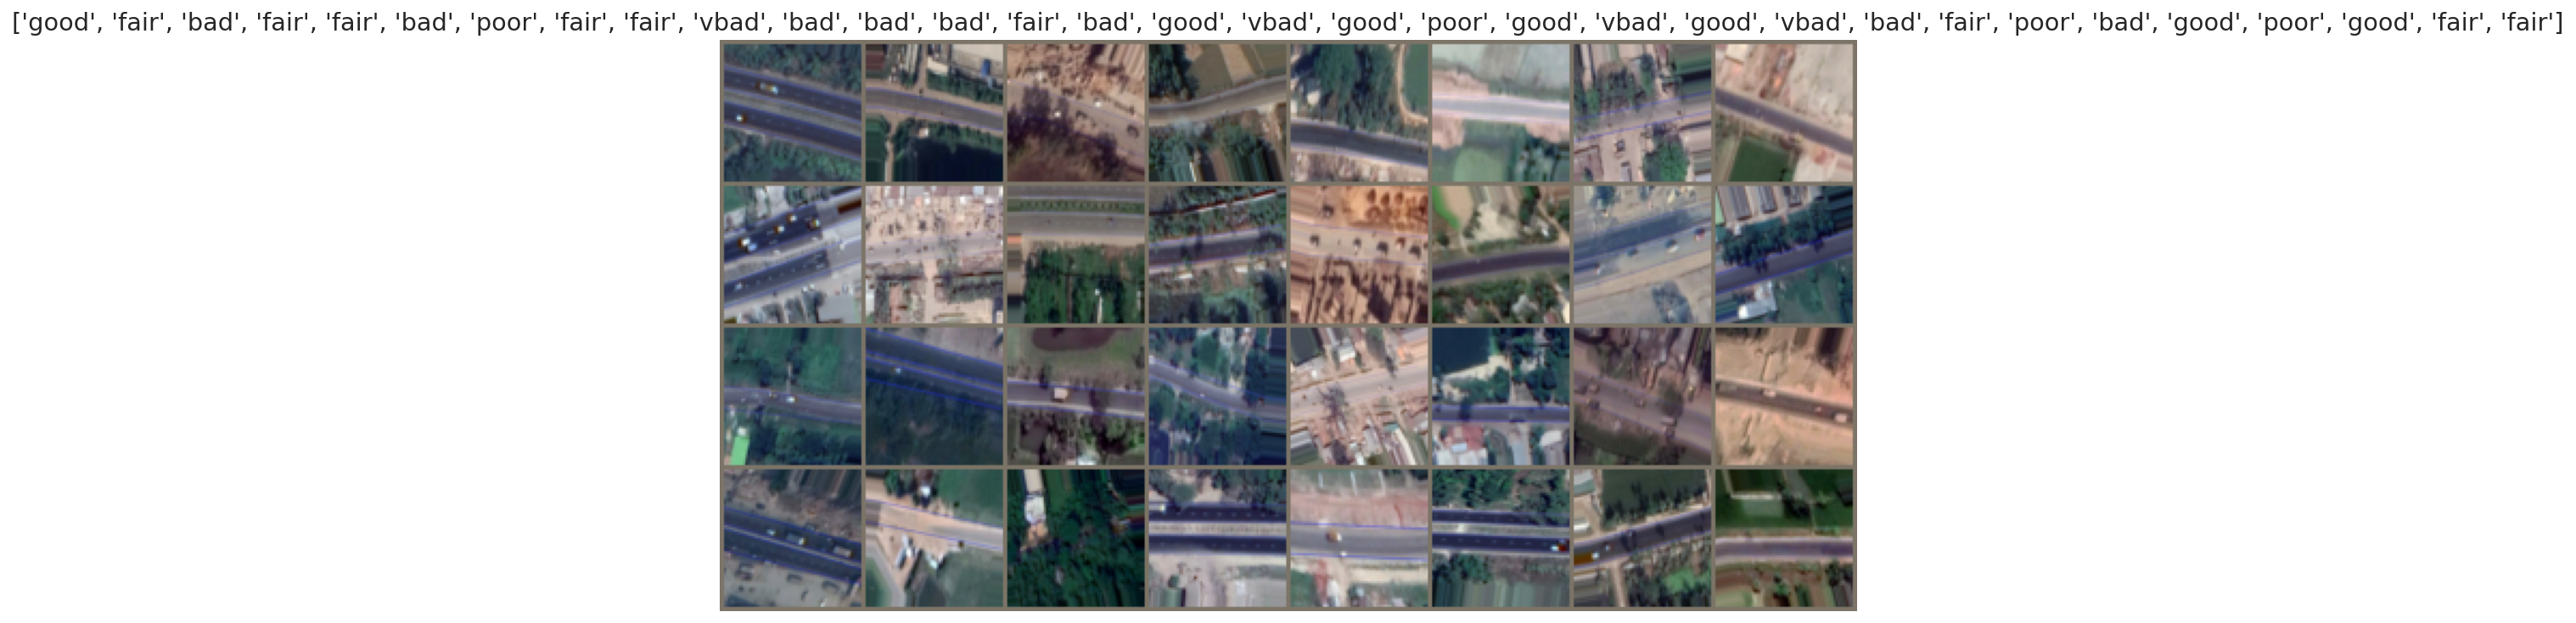

In [16]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
def create_model():
  model = models.mnasnet1_0(pretrained=True)
  return model.to(device)

In [18]:
base_model = create_model()

Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to /root/.cache/torch/hub/checkpoints/mnasnet1.0_top1_73.512-f206786ef8.pth


In [19]:
base_model

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [20]:
base_model.classifier[-1]

Linear(in_features=1280, out_features=1000, bias=True)

In [21]:
IN_FEATURES = base_model.classifier[-1].in_features 

final_fc = nn.Linear(IN_FEATURES,len(class_names) )

In [22]:
base_model.classifier[-1] = final_fc

In [23]:
print(base_model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=5, bias=True)
)


In [24]:
base_model.to(device)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [22]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=20):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [ ]:
%%time
#64*64
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/20
----------
Train loss 1.3125605640837745 accuracy 0.4642897889332573
Val   loss 1.4095585950906726 accuracy 0.4364880273660205

Epoch 2/20
----------
Train loss 0.9386417035856386 accuracy 0.6403308613804907
Val   loss 1.3126395154690398 accuracy 0.5076396807297605

Epoch 3/20
----------
Train loss 0.769970660934048 accuracy 0.7006274957216201
Val   loss 1.2146515435930612 accuracy 0.5550741163055872

Epoch 4/20
----------
Train loss 0.6691303756767816 accuracy 0.7399885909868796
Val   loss 0.9440334419841352 accuracy 0.6244013683010262

Epoch 5/20
----------
Train loss 0.5842203797269476 accuracy 0.7736451796919567
Val   loss 0.9032274022482444 accuracy 0.659521094640821

Epoch 6/20
----------
Train loss 0.5257612814324616 accuracy 0.8004563605248146
Val   loss 0.855083789838397 accuracy 0.675484606613455

Epoch 7/20
----------
Train loss 0.4665469098972143 accuracy 0.8197375926982317
Val   loss 0.711768004871176 accuracy 0.7204104903078677

Epoch 8/20
----------
Train loss

In [28]:
%%time
#224*224
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/20
----------
Train loss 0.9574925871497958 accuracy 0.6167712492869367
Val   loss 1.062309151020917 accuracy 0.6442417331812998

Epoch 2/20
----------
Train loss 0.6135553623257327 accuracy 0.7656018254420993
Val   loss 0.8817194603789936 accuracy 0.6919042189281642

Epoch 3/20
----------
Train loss 0.48319501900895884 accuracy 0.8142612664004564
Val   loss 0.7553423747691241 accuracy 0.7247434435575827

Epoch 4/20
----------
Train loss 0.38387442981130887 accuracy 0.854249857387336
Val   loss 0.63747618698261 accuracy 0.7685290763968072

Epoch 5/20
----------
Train loss 0.3008003621804018 accuracy 0.8860810039931546
Val   loss 0.6813749212297526 accuracy 0.766248574686431

Epoch 6/20
----------
Train loss 0.23245702492562634 accuracy 0.9150598973188819
Val   loss 0.7475645190270404 accuracy 0.7573546180159635

Epoch 7/20
----------
Train loss 0.17923757313142266 accuracy 0.9367940673131775
Val   loss 0.6783903769810091 accuracy 0.7717217787913341

Epoch 8/20
----------
Train 

In [26]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

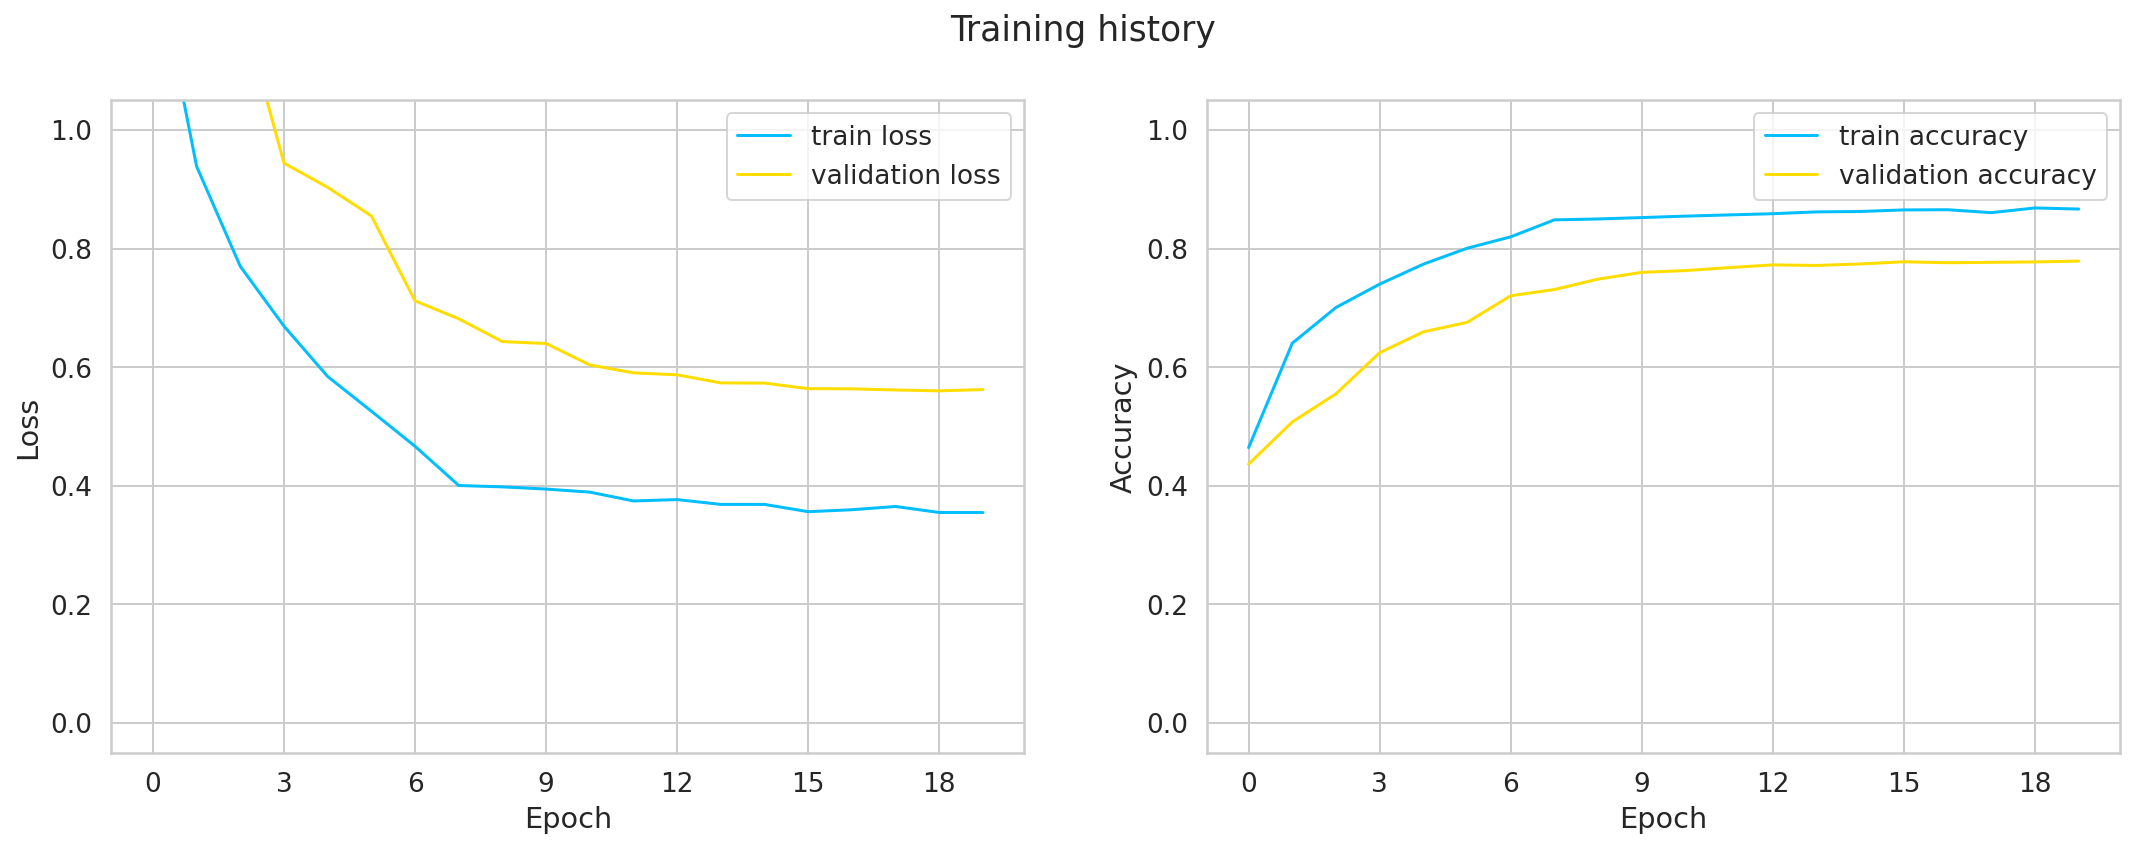

In [ ]:
#64*64
plot_training_history(history)

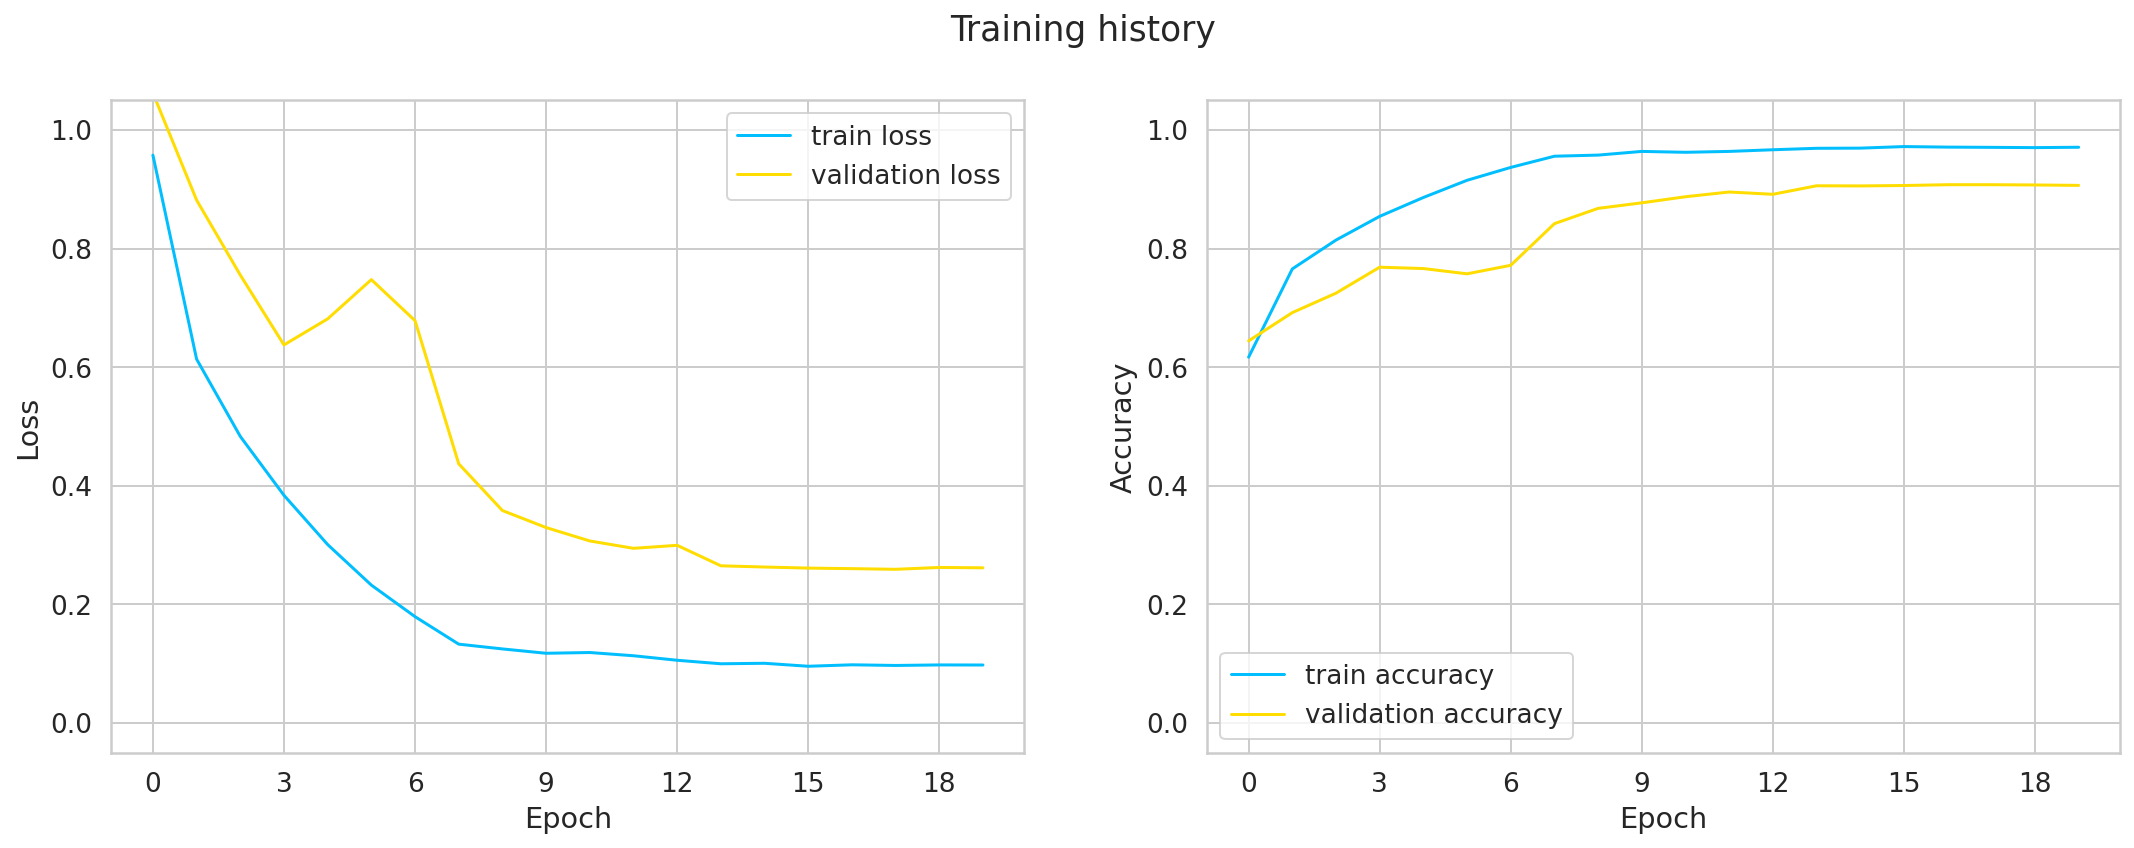

In [30]:
#224*224
plot_training_history(history)

# **Test Data**(unseen)

In [28]:
test_folders = sorted(glob('/content/drive/MyDrive/70:30_Datasets/test_set/*'))
len(test_folders)

5

In [29]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

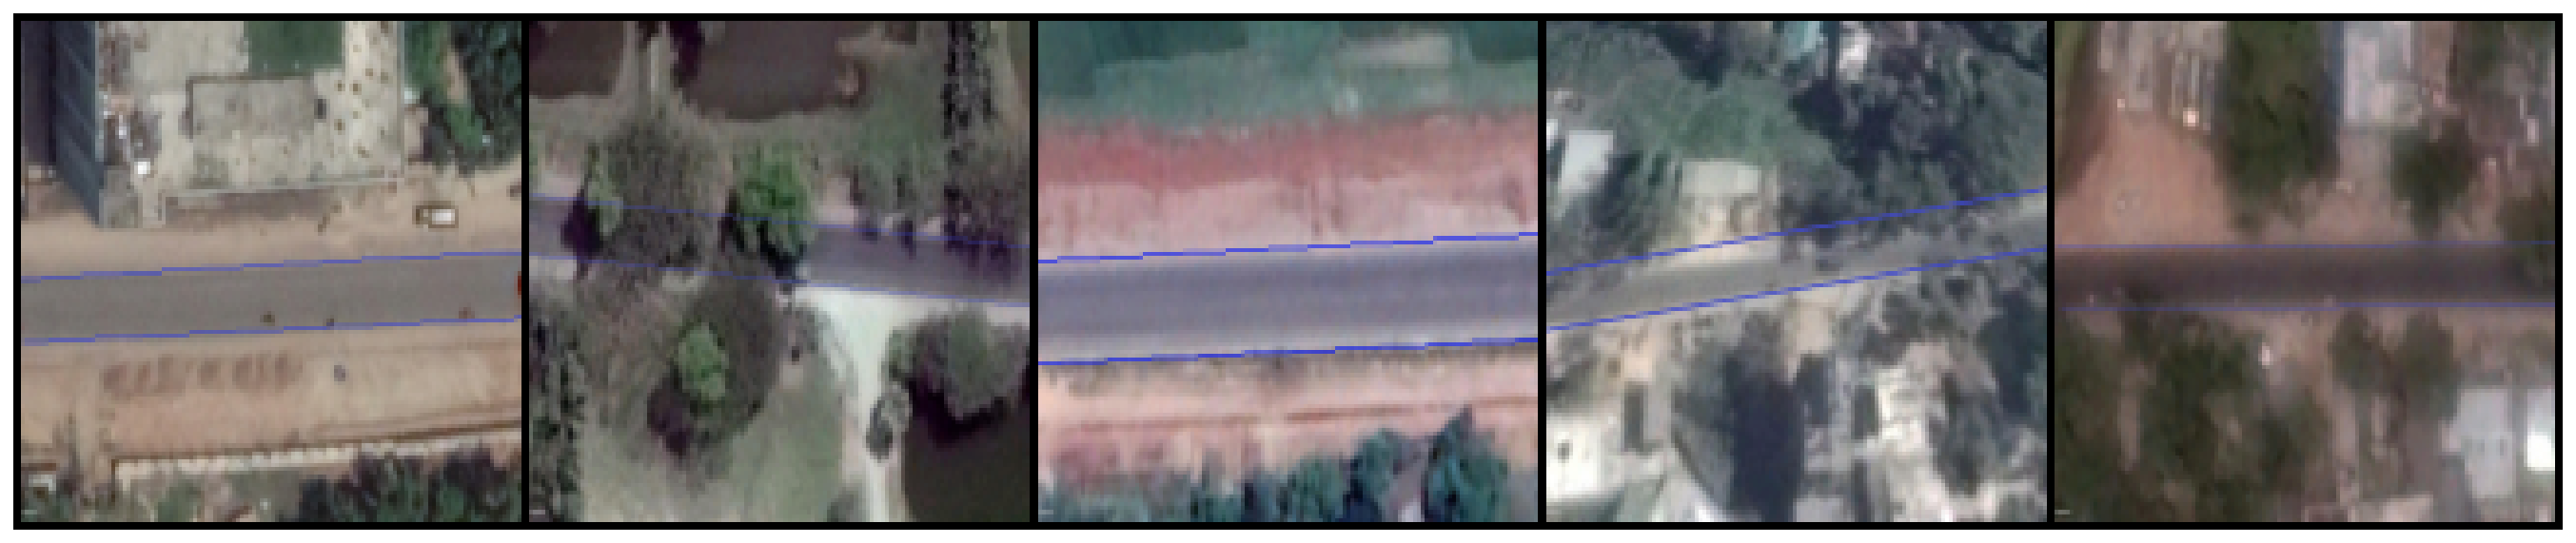

In [30]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in test_folders]
show_sign_grid(sample_images)

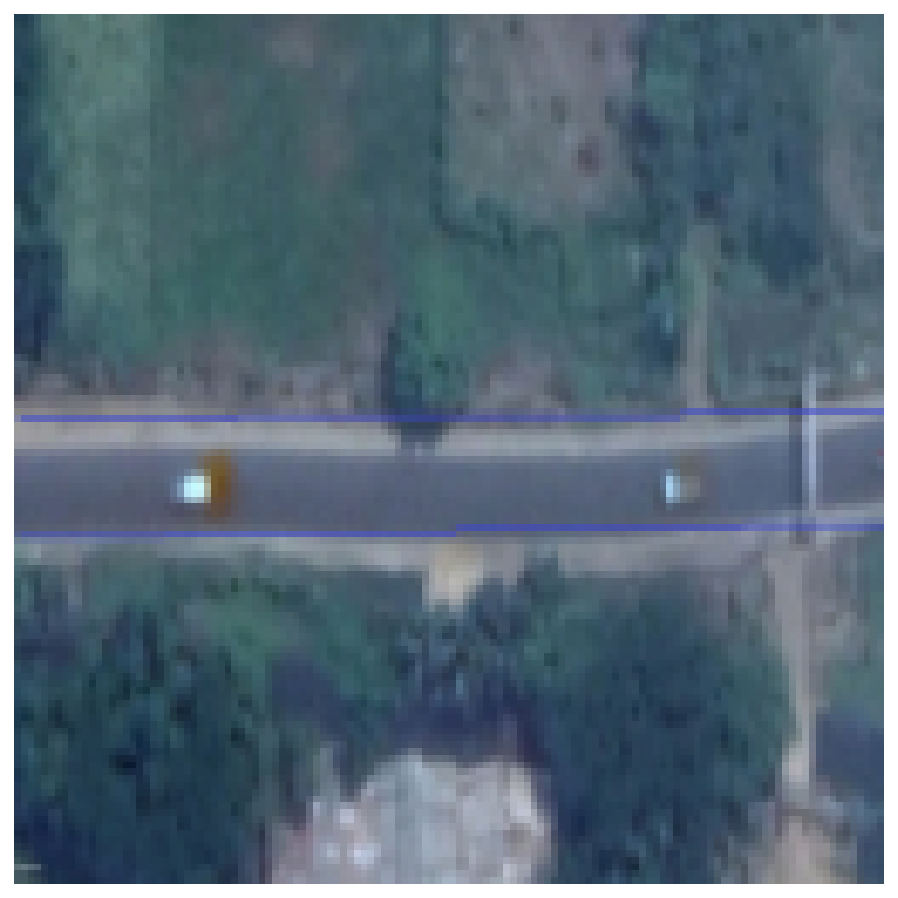

In [31]:
img_path = glob(f'{test_folders[4]}/*png')[1]

show_image(img_path)

In [32]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [33]:
!rm -rf data

DATA_DIR = Path('testx_data')

DATASETS = ['test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [34]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{test_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 251
fair: 290
good: 295
poor: 263
vbad: 231


In [35]:
#64*64
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=80),
  T.CenterCrop(size=64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [38]:
#224*224
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [36]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=5, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [37]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

{'test': 1330}

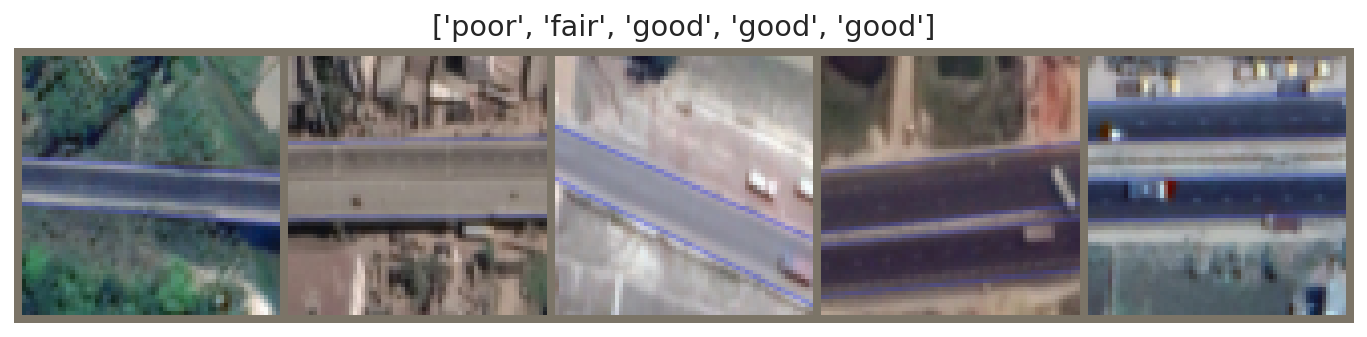

In [38]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [39]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure(figsize=(20,10))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}\n'  f'true: {class_names[labels[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

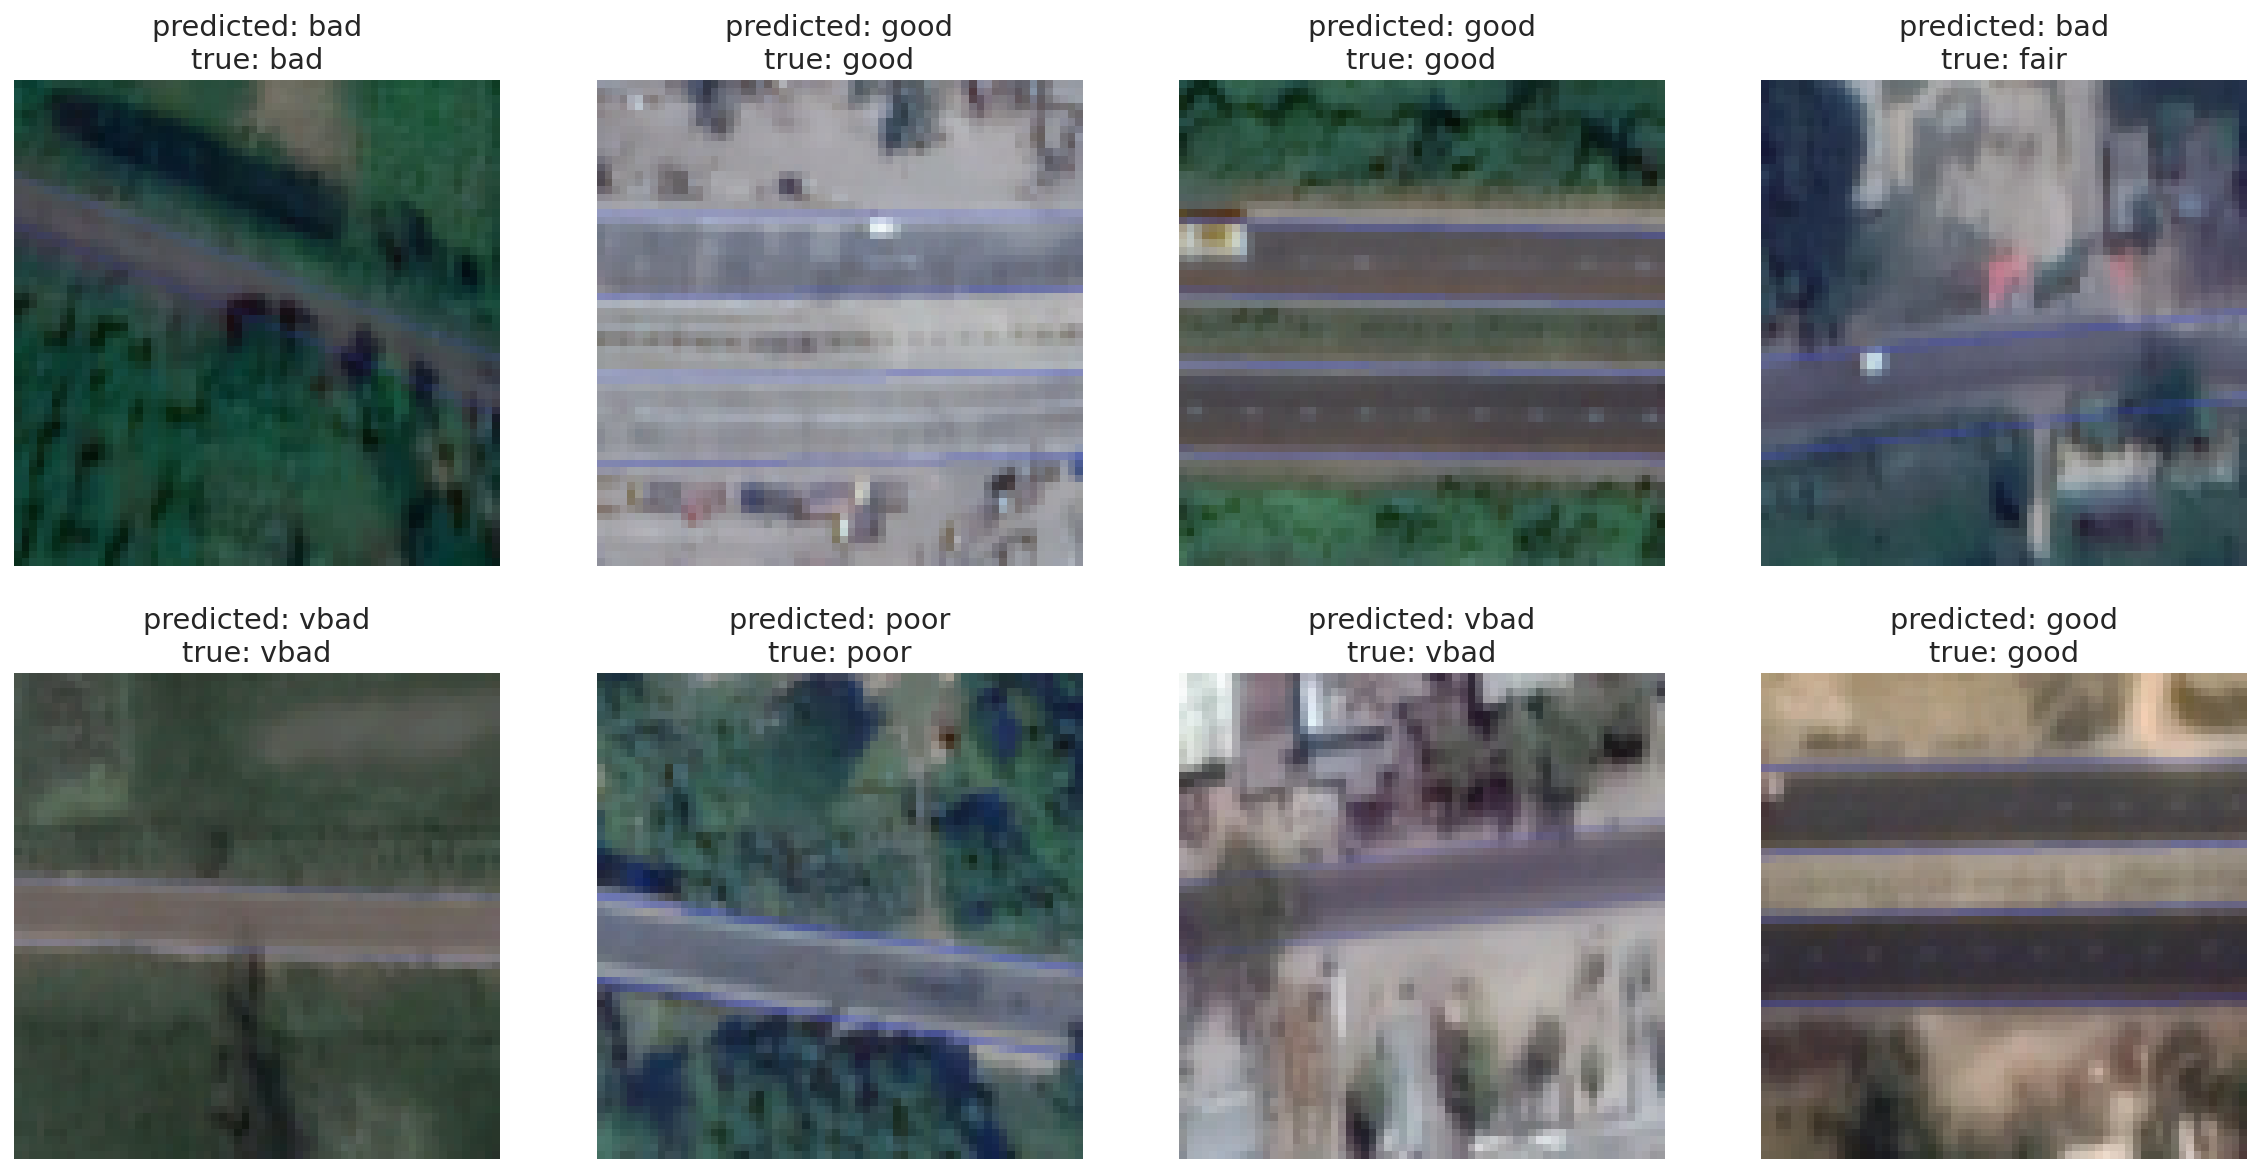

In [40]:
show_predictions(base_model, class_names, n_images=8)

In [41]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [42]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [ ]:
#64*64
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.73      0.73      0.73       251
        fair       0.64      0.58      0.61       290
        good       0.69      0.75      0.72       295
        poor       0.84      0.76      0.79       263
        vbad       0.70      0.80      0.75       231

    accuracy                           0.72      1330
   macro avg       0.72      0.72      0.72      1330
weighted avg       0.72      0.72      0.72      1330



In [46]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.87      0.84      0.85       251
        fair       0.85      0.66      0.74       290
        good       0.73      0.88      0.80       295
        poor       0.88      0.83      0.85       263
        vbad       0.75      0.87      0.81       231

    accuracy                           0.81      1330
   macro avg       0.82      0.81      0.81      1330
weighted avg       0.82      0.81      0.81      1330



In [47]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

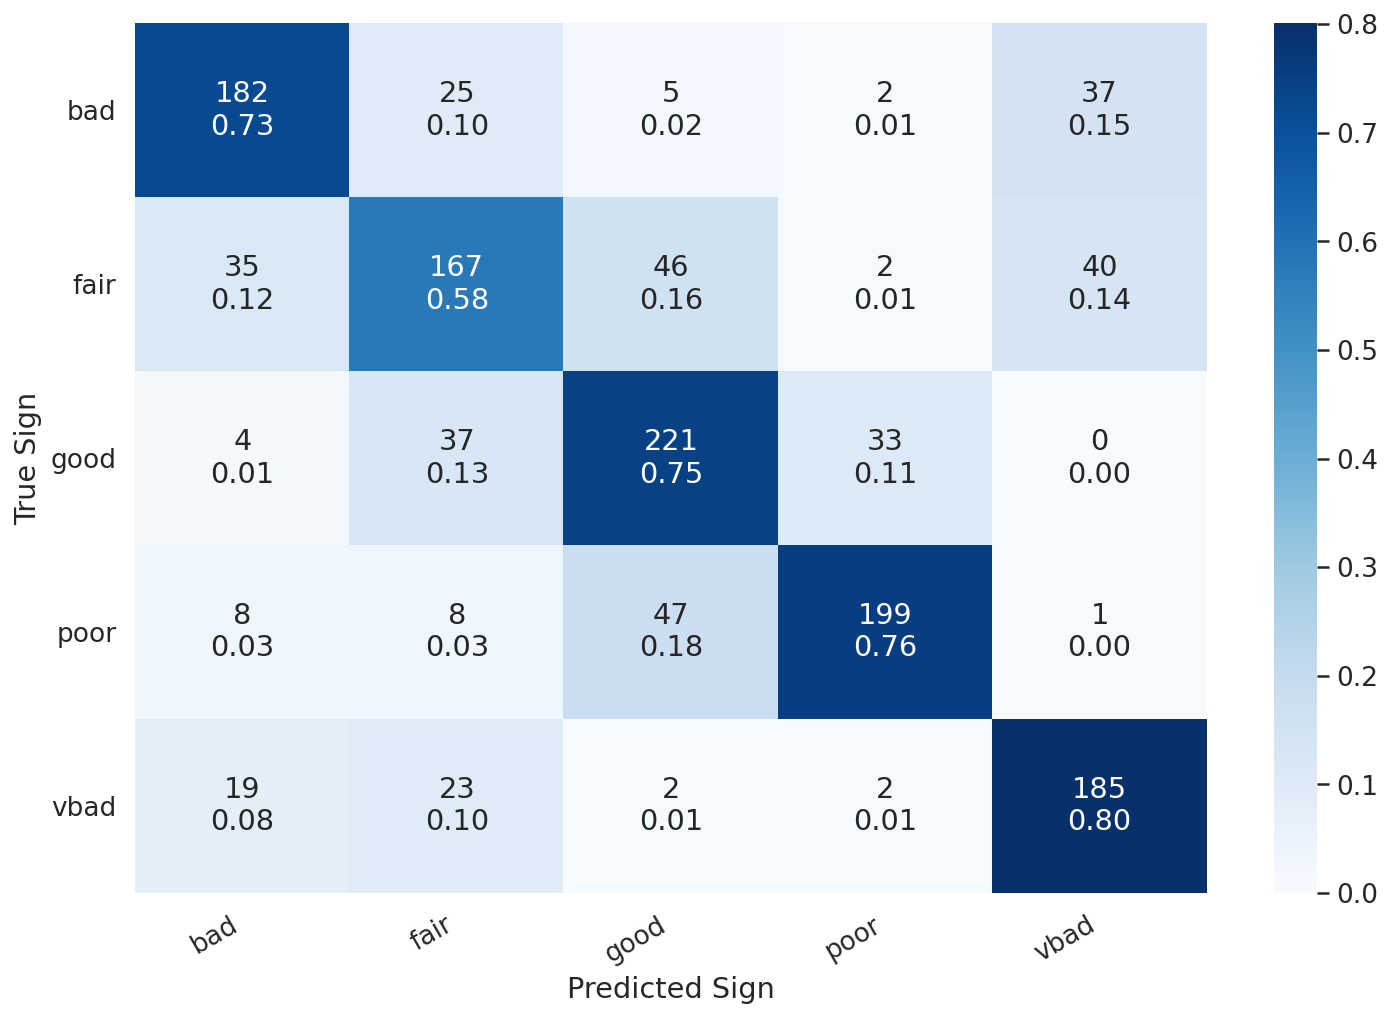

In [ ]:
#64*64
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

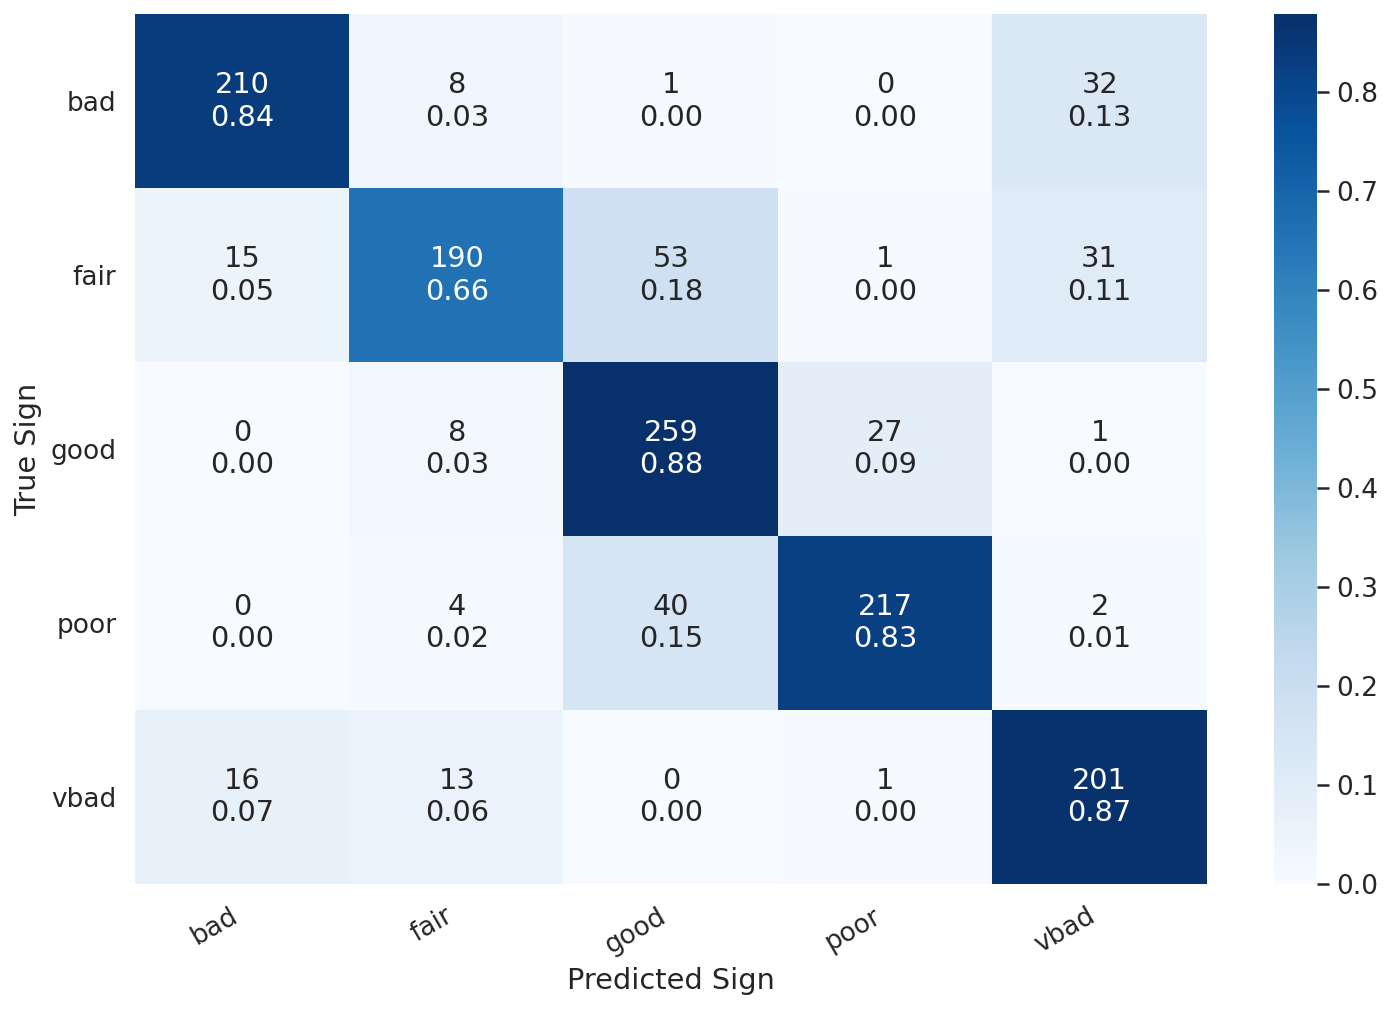

In [48]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

# **Hold out dataset(New Road for testing)**

In [46]:
held_folders = sorted(glob('/content/drive/MyDrive/heldoutV2/*'))
len(held_folders)

5

In [47]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

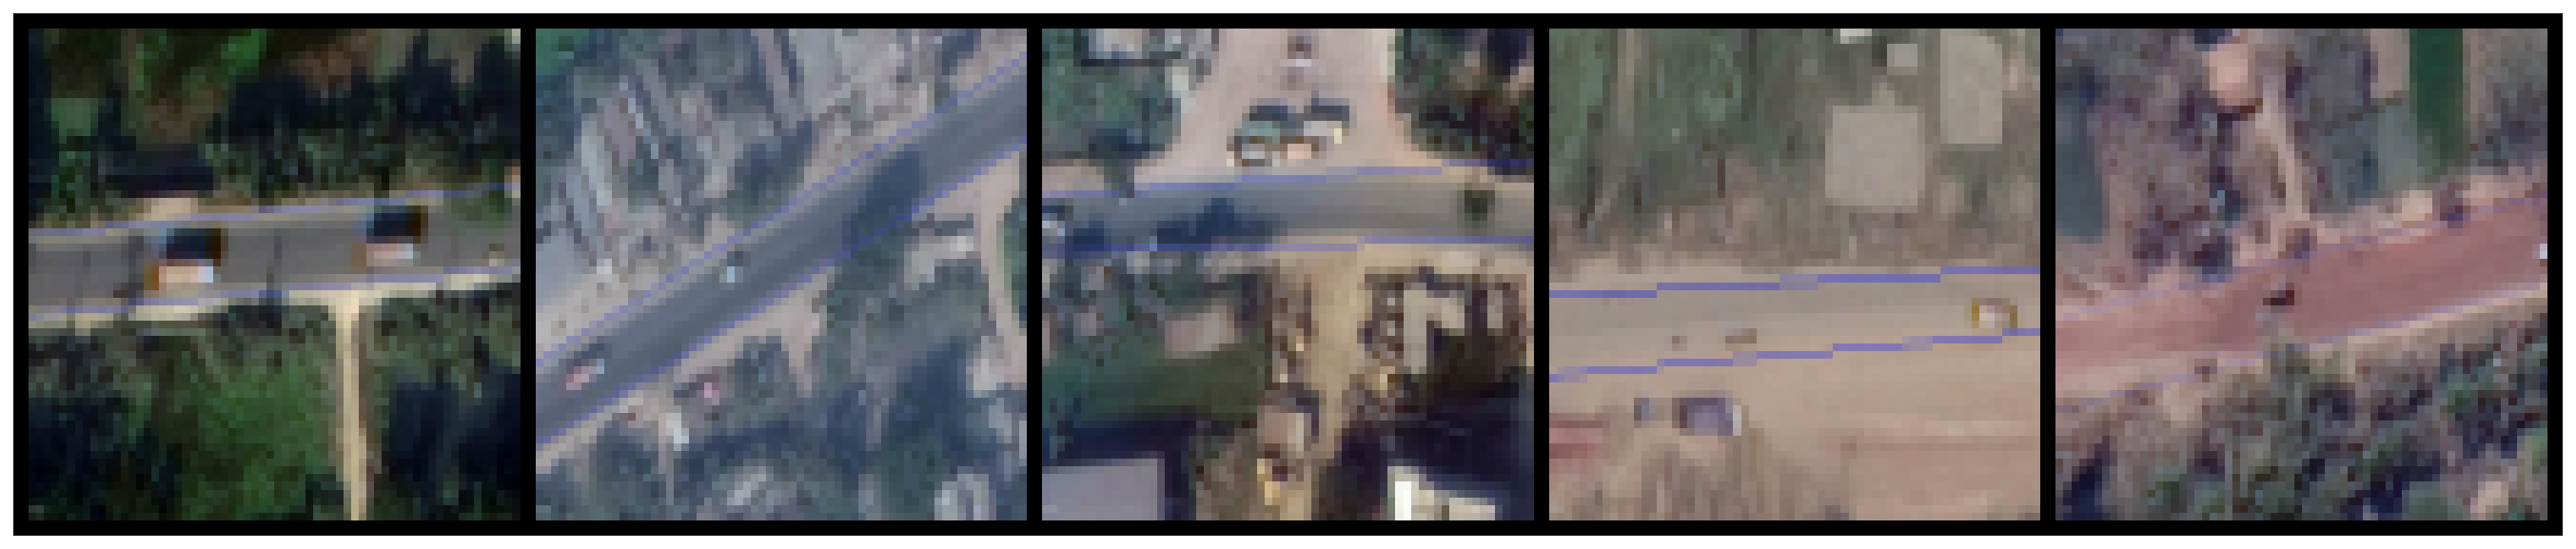

In [48]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in held_folders]
show_sign_grid(sample_images)

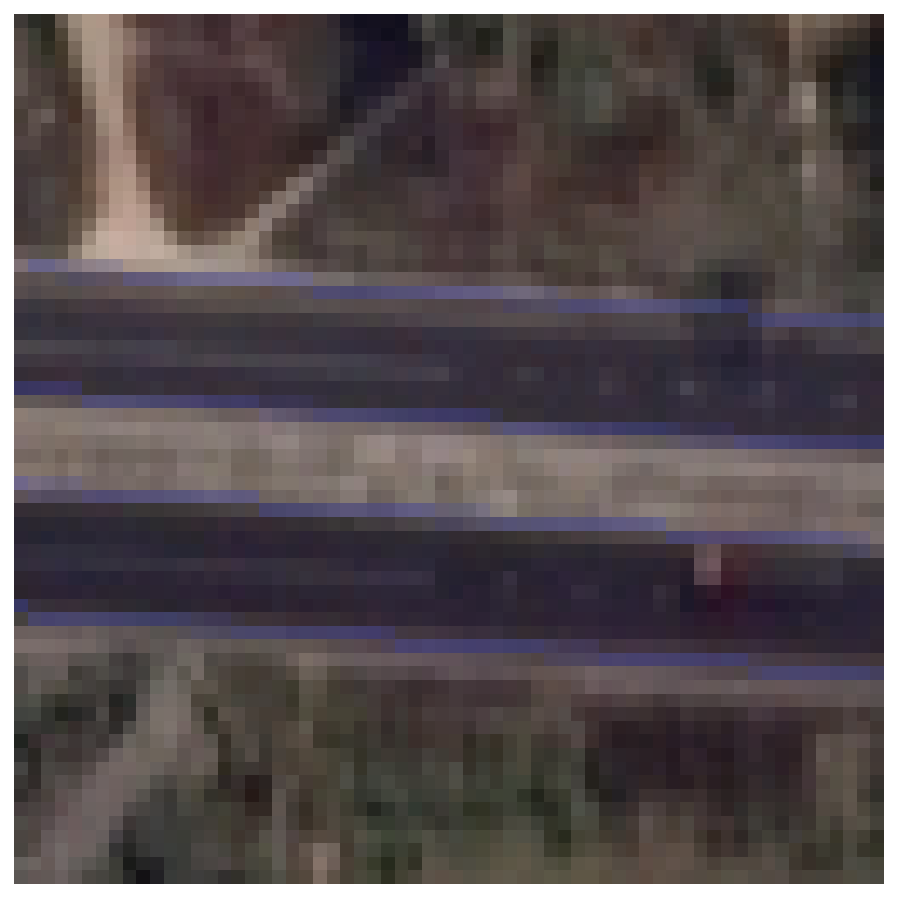

In [49]:
img_path = glob(f'{held_folders[2]}/*png')[20]

show_image(img_path)

In [50]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [51]:
!rm -rf data

DATA_DIR = Path('heldoutx_data')

DATASETS = ['heldout_test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [52]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{held_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 104
fair: 115
good: 113
poor: 91
vbad: 94


In [53]:
#64*64
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'heldout_test': T.Compose([
  T.Resize(size=80),
  T.CenterCrop(size=64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [56]:
#224*224
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'heldout_test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [54]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=10, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [55]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['heldout_test'].classes

dataset_sizes

{'heldout_test': 517}

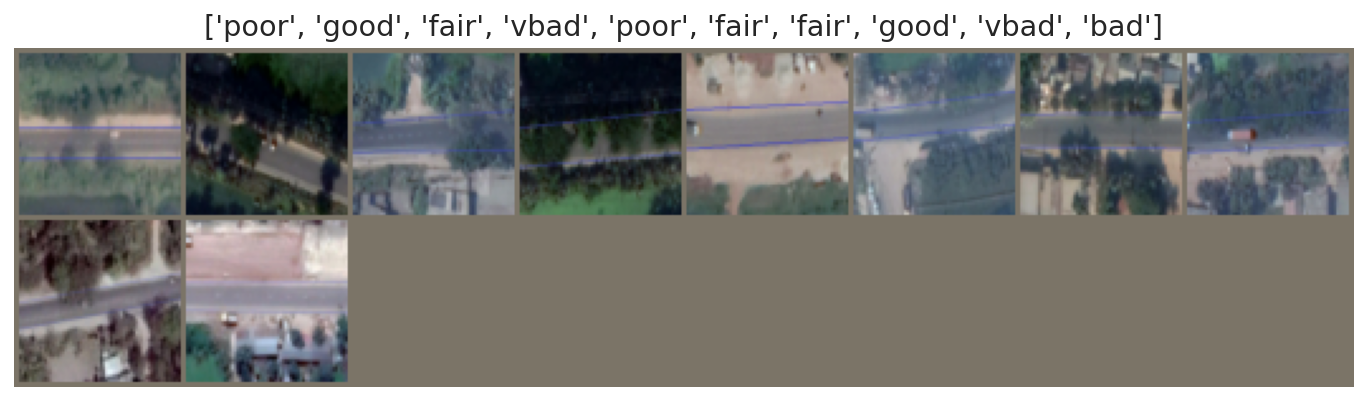

In [56]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['heldout_test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [57]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [58]:
y_pred, y_test = get_predictions(base_model, data_loaders['heldout_test'])

In [ ]:
#64*64
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.54      0.65      0.59       104
        fair       0.34      0.58      0.43       115
        good       0.46      0.32      0.38       113
        poor       0.79      0.42      0.55        91
        vbad       0.77      0.57      0.66        94

    accuracy                           0.51       517
   macro avg       0.58      0.51      0.52       517
weighted avg       0.57      0.51      0.51       517



In [63]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.70      0.71      0.70       104
        fair       0.37      0.53      0.44       115
        good       0.42      0.32      0.36       113
        poor       0.74      0.34      0.47        91
        vbad       0.53      0.67      0.59        94

    accuracy                           0.51       517
   macro avg       0.55      0.51      0.51       517
weighted avg       0.54      0.51      0.51       517



In [64]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

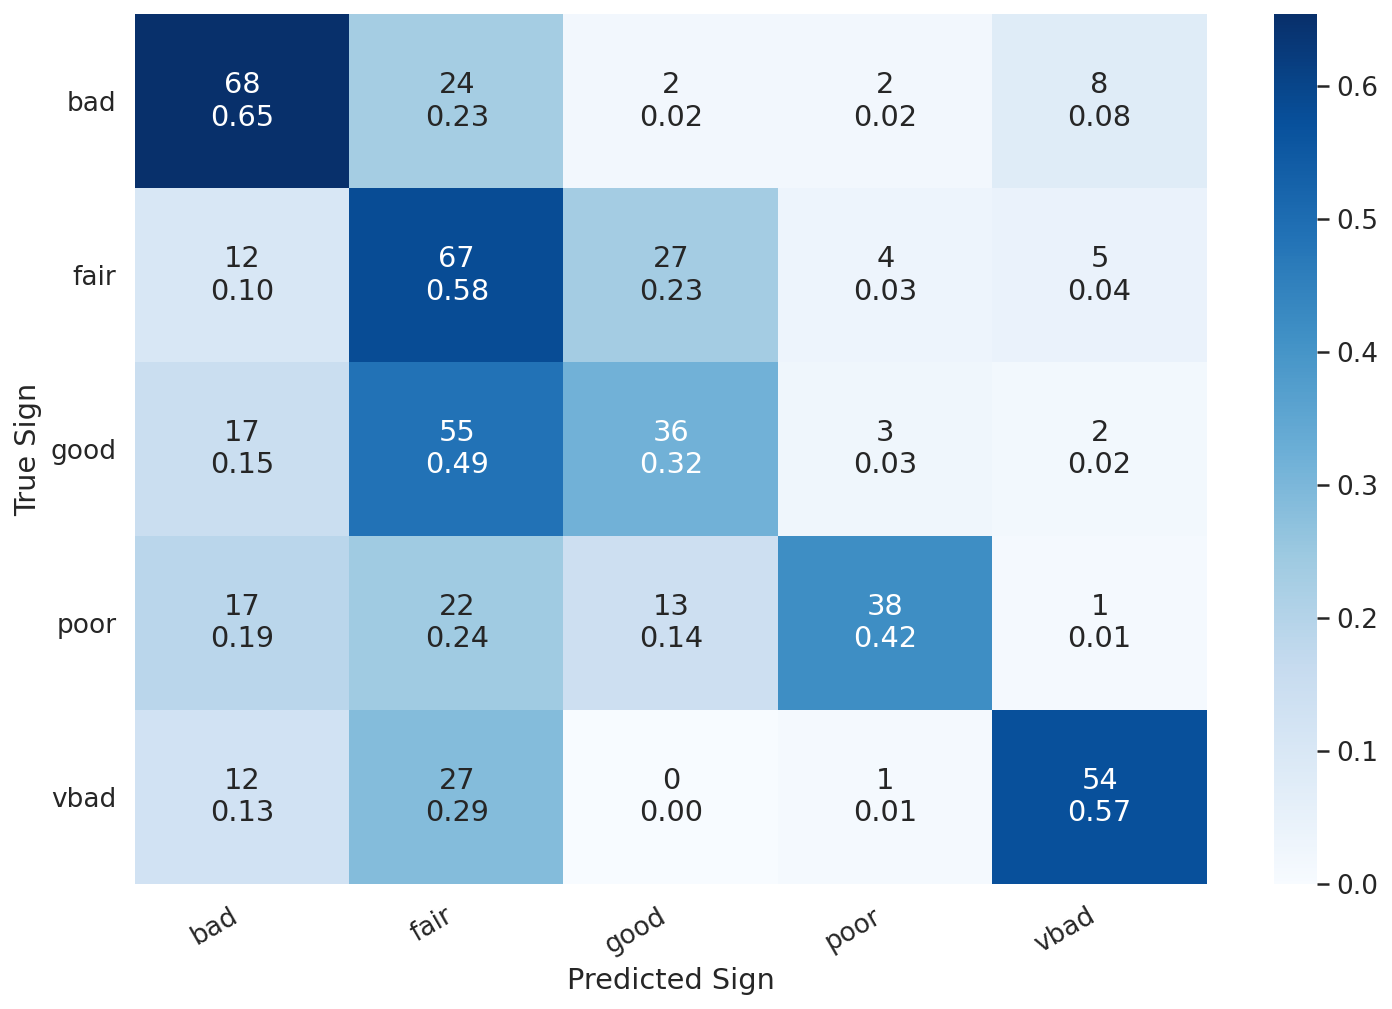

In [ ]:
#64*64
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

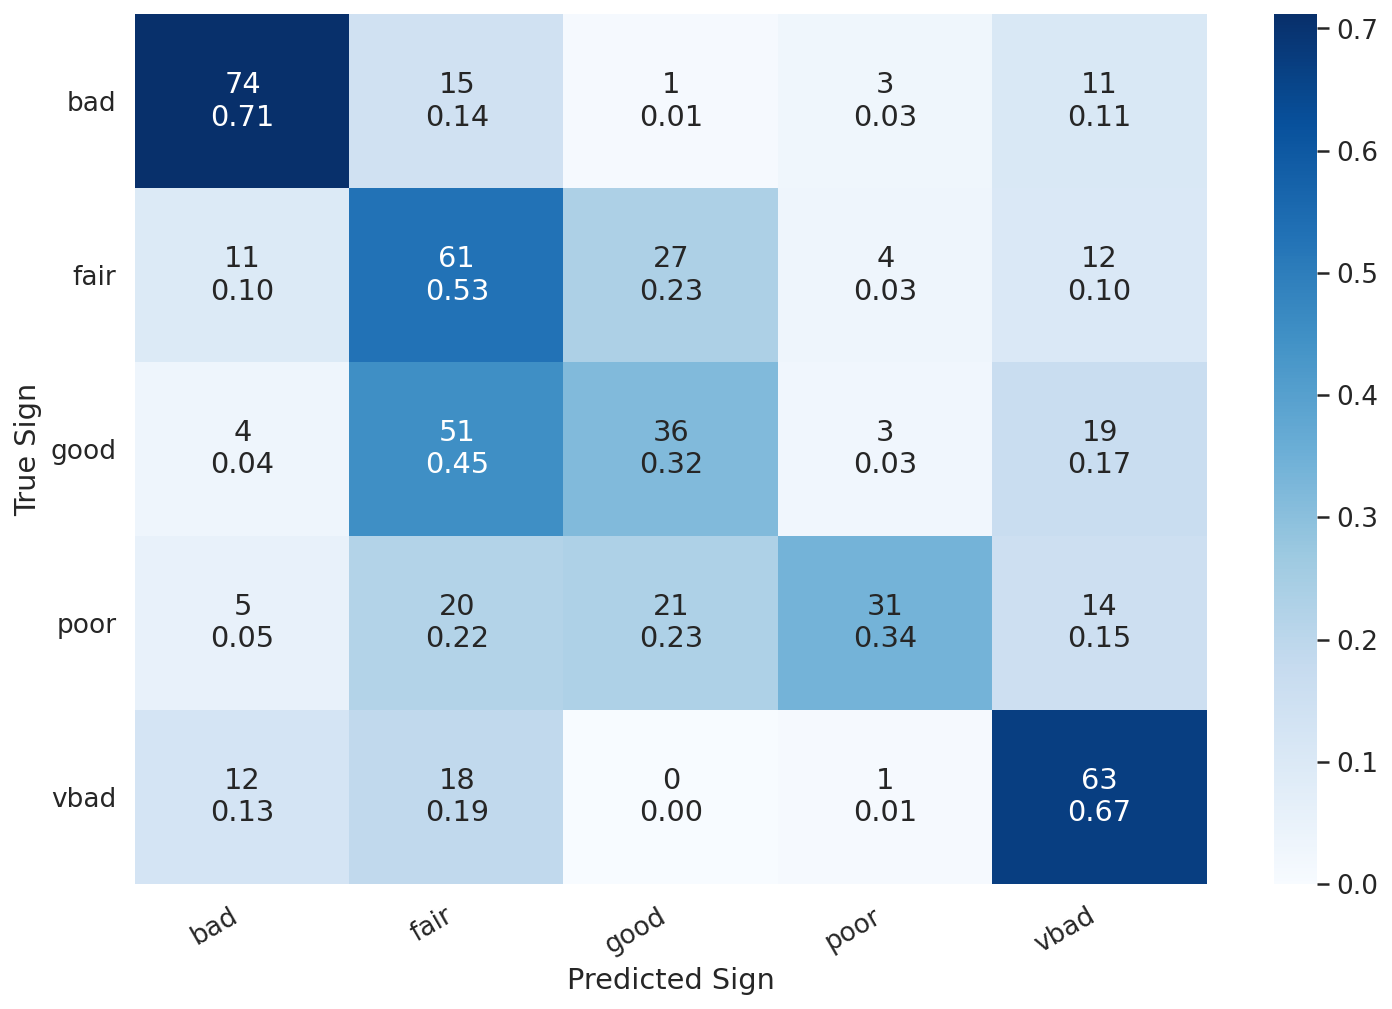

In [65]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

In [62]:
root_path = '/content/drive/My Drive/'

In [67]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(base_model.state_dict(), root_path + 'AlexNetmodel7030.pkl') 

In [68]:
load_model = True

if load_model is True:
    base_model.load_state_dict(torch.load(root_path + 'AlexNetmodel7030.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


In [69]:
import matplotlib.pyplot as plt 
import numpy as np

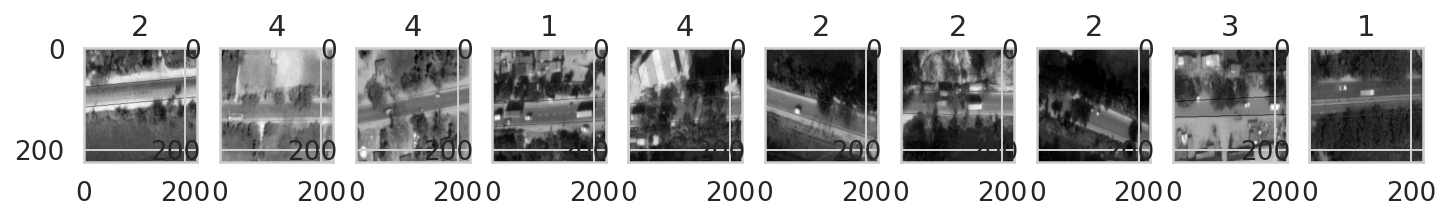

In [70]:
for images, labels in data_loaders['heldout_test']:
    break
    
fig, ax = plt.subplots(1, 10)
for i in range(10):
    show_img = images[i][0].numpy().reshape(224, 224)
    ax[i].imshow(show_img,cmap='gray')
    ax[i].set_title(int(labels[i]))
    
plt.show()

In [71]:
predictions = base_model.forward(images[:10].view(-1, 3,224,224).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [4 4 4 4 1 2 4 0 3 1]
